<a href="https://colab.research.google.com/github/dweinflash/RNN/blob/master/PixelRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/philkuz/PixelRNN.git

In [ ]:
import os

import numpy as np
from tqdm import tqdm
import tensorflow as tf

!pip install scipy==1.2.0

from PixelRNN.utils import *
from PixelRNN.ops import *
from PixelRNN.statistic import Statistic

In [ ]:
hyperparams = {# network
    "model" : "pixel_cnn", # name of model [pixel_rnn, pixel_cnn]
    "batch_size" : 100, # size of a batch
    "hidden_dims" : 16, # dimesion of hidden states of LSTM or Conv layers
    "recurrent_length" : 7, # the length of LSTM or Conv layers
    "out_hidden_dims" : 32, # dimesion of hidden states of output Conv layers
    "out_recurrent_length" : 2, # the length of output Conv layers
    "use_residual" : False, # whether to use residual connections or not
    "use_dynamic_rnn" : False, # whether to use dynamic_rnn or not

    # training
    "max_epoch" : 20, # # of step in an epoch
    "test_step" : 10, # # of step to test a model
    "save_step" : 5, # # of step to save a model
    "learning_rate" : 1e-3, # learning rate
    "grad_clip" : 1, # value of gradient to be used for clipping
    "use_gpu" : True, # whether to use gpu for training

    # data
    "data" : "mnist", # name of dataset 
    "data_dir" : "MNIST-data", # name of data directory
    "sample_dir" : "samples", # name of sample directory

    # Debug
    "is_train" : True, # training or testing
    "display" : False, # whether to display the training results or not
    "random_seed" :  123 # random seed for python
}
p = dotdict(hyperparams)

In [ ]:
if "random_seed" in p:
    tf.set_random_seed(p.random_seed)
    np.random.seed(p.random_seed)

In [ ]:
# TODO add hyperparams to model saving
model_dir = setup_model_saving(p.model, p.data, hyperparams)
DATA_DIR = p.data_dir
SAMPLE_DIR = os.path.join(model_dir, p.sample_dir)

check_and_create_dir(DATA_DIR)
check_and_create_dir(SAMPLE_DIR)

# prepare dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

next_train_batch = lambda x: mnist.train.next_batch(x)[0]
next_test_batch = lambda x: mnist.test.next_batch(x)[0]

height, width, channel = 28, 28, 1

train_step_per_epoch = mnist.train.num_examples // p.batch_size
test_step_per_epoch = mnist.test.num_examples // p.batch_size

In [ ]:
def pixelRNN(height, width, channel, params):
    """
    Args
    height, width, channel - the dimensions of the input
    params -- the hyperparameters of the network
    """
    input_shape = [None, height, width, channel] if params.use_gpu else [None, channel, height, width]
    inputs = tf.placeholder(tf.float32, input_shape)

    # input of main convolutional layers
    scope = "conv_inputs"
    conv_inputs = conv2d(inputs, params.hidden_dims, [7, 7], "A", scope=scope)
    
    # main convolutions layers
    last_hid = conv_inputs
    for idx in range(params.recurrent_length):
        scope = 'CONV%d' % idx
        last_hid = conv2d(last_hid, 3, [1, 1], "B", scope=scope)
        print("Building %s" % scope)

    # output convolutional layers
    for idx in range(params.out_recurrent_length):
        scope = 'CONV_OUT%d' % idx
        last_hid = tf.nn.relu(conv2d(last_hid, params.out_hidden_dims, [1, 1], "B", scope=scope))
        print("Building %s" % scope)

    conv2d_out_logits = conv2d(last_hid, 1, [1, 1], "B", scope='conv2d_out_logits')
    output = tf.nn.sigmoid(conv2d_out_logits)
    return inputs, output, conv2d_out_logits

inputs, output, conv2d_out_logits = pixelRNN(height, width, channel, p)

In [ ]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=conv2d_out_logits, labels=inputs, name='loss'))

optimizer = tf.train.RMSPropOptimizer(p.learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

new_grads_and_vars = [(tf.clip_by_value(gv[0], -p.grad_clip, p.grad_clip), gv[1]) for gv in grads_and_vars]
optim = optimizer.apply_gradients(new_grads_and_vars)
 
# show_all_variables()
print("Building %s finished!" % p.model)

In [ ]:
def predict(sess, images, inputs, output):
    return sess.run(output, {inputs: images})
def generate_occlusions(sess, height, width, inputs, output):
    samples = occlude(images, height, width)
    starting_position = [0,height//2]
    for i in range(starting_position[1], height):
        for j in range(starting_position[0], width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]
    return samples

def generate(sess, height, width, inputs, output):
    samples = np.zeros((100, height, width, 1), dtype='float32')

    for i in range(height):
        for j in range(width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]

    return samples

In [ ]:
# with tf.Session() as sess:
sess = tf.Session()
stat = Statistic(sess, p.data, model_dir, tf.trainable_variables(), p.test_step)
stat.load_model()
init = tf.global_variables_initializer()

sess.run(init)
stat.start()
print("Start training")

initial_step = stat.get_t() if stat else 0
# iterator = trange(p.max_epoch, ncols=70, initial=initial_step)
iterator = tqdm(range(p.max_epoch))

for epoch in iterator:
    # print('Start epoch')
    # 1. train
    total_train_costs = []
    for idx in range(train_step_per_epoch):
        images = binarize(next_train_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        _, cost = sess.run([optim, loss], feed_dict={ inputs: images })
        total_train_costs.append(cost)
    # print('Start testing')
    # 2. test
    total_test_costs = []
    for idx in range(test_step_per_epoch):
        images = binarize(next_test_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        cost = sess.run(loss, feed_dict={ inputs : images })
        total_test_costs.append(cost)

    avg_train_cost, avg_test_cost = np.mean(total_train_costs), np.mean(total_test_costs)

    stat.on_step(avg_train_cost, avg_test_cost)
    # print('Start generation')
    # 3. generate samples
    samples = generate_occlusions(sess, height, width, inputs, output)
    path = save_images(samples, height, width, 10, 10, 
        directory=SAMPLE_DIR, prefix="epoch_%s" % epoch)
    iterator.set_description("train loss: %.3f, test loss: %.3f" % (avg_train_cost, avg_test_cost))

In [ ]:
# with tf.Session() as sess:
samples = generate_occlusions(sess, height, width, inputs, output)
save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)

'run/mnist/pixel_cnn4/samples/sample_0.jpg'

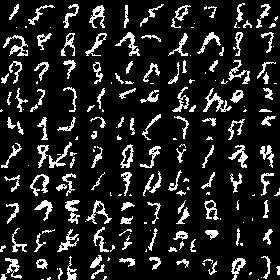

In [ ]:
from IPython.display import Image
fname = save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)
Image(filename=fname)

In [ ]:
sess.close()